# Bubble wall velocity under LTE

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt
import plotter as pl
from helperFunctions import derivative, alpha_p, cs_sq, dYdtau, dvTdxi, r_func, μ, w

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Sech = lambda x: 1/np.cosh(x)
Tanh = np.tanh
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


def Plot(fun, xminmax, n=100,xfun=np.linspace, xlog=False, ylog=False):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

## Prepare

Import model

In [2]:
import SM_model as m

In [3]:
mod = m.SM(1,0.007285228,636.8644639563023)

Model initialized.
g2 = 1
λ = 0.007285228
μh = 25.236173718618723


In [4]:
mod.findTc()
mod.findTn()

Finding Tc...
Critical temperature found! Tc = 56.636213599704206
v_c/Tc = 2.805112061801922
Finding Tn...
Tunneling at T = 56.6162135997042
S3/T = 1776610.8204163732
Tunneling at T = 56.5962135997042
S3/T = 451853.4873632733
Tunneling at T = 56.576213599704204
S3/T = 203892.620674333
Tunneling at T = 56.5562135997042
S3/T = 116379.02610614893
Tunneling at T = 56.536213599704205
S3/T = 75553.78881297384
Tunneling at T = 56.5162135997042
S3/T = 53207.22596873181
Tunneling at T = 56.496213599704205
S3/T = 39631.405939377415
Tunneling at T = 56.4762135997042
S3/T = 30754.565784947874
Tunneling at T = 56.456213599704206
S3/T = 24623.812734348416
Tunneling at T = 56.4362135997042
S3/T = 20206.517107542953
Tunneling at T = 56.4162135997042
S3/T = 16914.527924929538
Tunneling at T = 56.396213599704204
S3/T = 14392.707460129765
Tunneling at T = 56.3762135997042
S3/T = 12416.149909538079
Tunneling at T = 56.356213599704205
S3/T = 10836.688220715478
Tunneling at T = 56.3362135997042
S3/T = 9553.

In [5]:
mod.findα()
mod.findβH()

α = 0.02095131796505928
β/H = 5236.321404242424


In [6]:
Vtot=mod.Vtot
hv = np.array([0.0])
lv = np.array([mod.Tnvev])
Tnuc = mod.Tn

In [7]:
from helperFunctions import a

## Solving the boundary conditions for deflagration

In [8]:
def p(V, T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    return -V(v, T)

def e(V, T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    def VT(T):
        return V(v, T)
    return - T * derivative(VT, T) + VT(T)

def ω(V, T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    def VT(T):
        return V(v, T)
    return - T * derivative(VT, T) 

In [9]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

def match_pe(vp,vm, Tp, Tm, hv, lv):
    pp = p(Vtot, Tp, hv)
    pm = p(Vtot, Tm, lv)
    ep = e(Vtot, Tp, hv)
    em = e(Vtot, Tm, lv)
    vpvm = (pp - pm)/(ep - em)
    ratio = (em + pp)/(ep + pm)
    return np.array([vp* vm- vpvm, vp/vm - ratio])

def match_T(vp,vm, Tp, Tm, hv, lv):
    pp = p(Vtot, Tp, hv)
    pm = p(Vtot, Tm, lv)
    ωp = ω(Vtot, Tp, hv)
    ωm = ω(Vtot, Tm, lv)
    γp = 1/Sqrt(1-vp**2)
    γm = 1/Sqrt(1-vm**2)
    T33p = ωp * vp**2 * γp**2 + pp
    T33m = ωm * vm**2 * γm**2 + pm
    T30p = ωp * vp * γp**2
    T30m = ωm * vm * γm**2
    return np.array([T33p - T33m, T30p - T30m])

def find_Tsh(Tm, vw, type='def'):
    if type=='def':
        guess_sol = optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[vw*0.8,Tnuc])
    elif type=='hyb':
        guess_sol = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.5,Tnuc])

    # Integrate outside the wall to the shock-wave front
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        try:
            xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max)
        except:
            xsh = xi_max
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)

    def sh_match_2(Tshp):
        ap = alpha_p(Vtot, Tshp, T_prof(xsh), hv, hv)
        r = r_func(Vtot, Tshp, T_prof(xsh), hv, hv)
        vp = xsh
        vm = μ(xsh, v_prof(xsh))
        ratio = 3 + (1-3*ap)*r
        ratio = ratio/(1+3*(1+ap)*r)
        return vp/vm - ratio
    Tshp = optimize.newton(sh_match_2, T_prof(xsh))
    return Tshp

In [10]:
Tnuc

53.31938236598749

In [11]:
find_Tsh(53, 0.1)

53.14976809754261

In [12]:
Tm = 53
vw = 0.55
print(optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.4,Tnuc]))
print(optimize.fsolve(lambda x:match_pe(x[0], vw, x[1], Tm,hv, lv),[0.4,Tnuc]))
print(optimize.fsolve(lambda x:match_T(x[0], vw, x[1], Tm,hv, lv),[0.4,Tnuc]))

[ 0.45891026 56.43588515]
[ 0.45891026 56.43588515]
[ 0.45891026 56.43588515]


In [13]:
guess_sol = optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.4,Tnuc])

In [49]:
vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
xi_max = vsol.y[2].max()
xi_max_index = vsol.y[2].argmax()
v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
try:
    xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max)
except:
    xsh = xi_max

In [17]:
xsh

0.5945878172821732

In [50]:
def sh_match(Tshp):
    ap = alpha_p(Vtot, Tshp, T_prof(xsh), hv, hv)
    r = r_func(Vtot, Tshp, T_prof(xsh), hv, hv)
    vp = xsh
    vm = μ(xsh, v_prof(xsh))
    vpvm = 1-(1-3*ap)*r
    vpvm = vpvm/(3-3*(1+ap)*r)
    return vpvm - vp*vm

def sh_match_2(Tshp):
    ap = alpha_p(Vtot, Tshp, T_prof(xsh), hv, hv)
    r = r_func(Vtot, Tshp, T_prof(xsh), hv, hv)
    vp = xsh
    vm = μ(xsh, v_prof(xsh))
    ratio = 3 + (1-3*ap)*r
    ratio = ratio/(1+3*(1+ap)*r)
    return vp/vm - ratio

In [27]:
μ(xsh, v_prof(xsh))

0.5613408026899902

In [74]:
r_func(Vtot, 52.82540856769438, 54.37164544, hv, hv)

0.8911085523653911

In [23]:
sh_match(53)

0.0004041081398660218

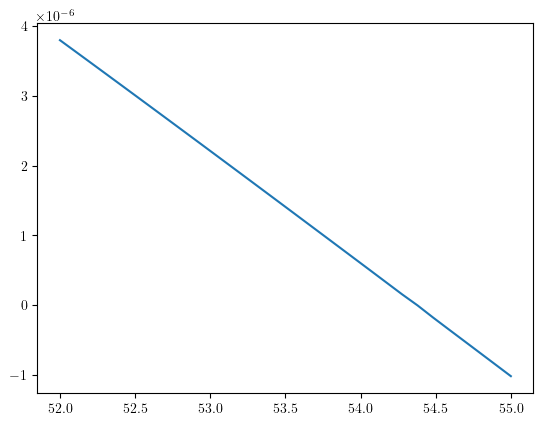

In [29]:
Plot(sh_match, (52,55), n=30)

In [38]:
optimize.newton(sh_match_2, 53.6)

52.82540856769438

In [33]:
T_prof(xsh)

array(54.37164544)

In [54]:
find_Tsh(53.3,0.1)

53.432512029081664

## Solve hybrid boundary conditions

In [302]:
vw = 0.65

In [79]:
Tm=53
cs_sq(Vtot, Tm, lv)**0.5

0.5701085533708864

In [82]:
guess_sol = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.5,Tnuc])

In [83]:
guess_sol

array([ 0.46465257, 57.1401147 ])

In [84]:
ini = np.array([μ(vw, guess_sol[0]), guess_sol[1], vw])

In [91]:
sol=integrate.solve_ivp(dYdtau, (10,1), ini, args=(Vtot, hv), t_eval=np.linspace(10, 1,100))

In [92]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.000e+01  9.909e+00 ...  1.091e+00  1.000e+00]
        y: [[ 1.877e-01  1.781e-01 ...  5.681e-04  5.347e-04]
            [ 5.714e+01  5.687e+01 ...  5.142e+01  5.142e+01]
            [ 6.000e-01  6.048e-01 ...  5.798e-01  5.797e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0

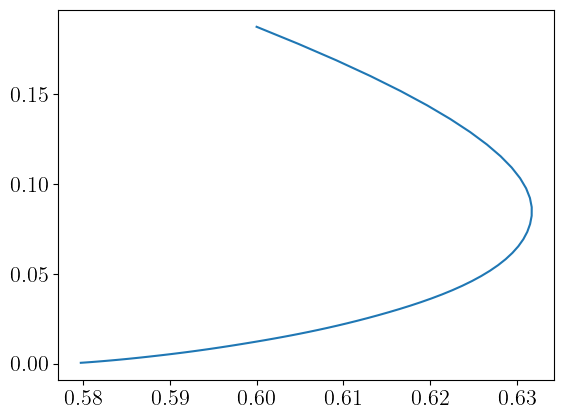

In [93]:
plt.plot(sol.y[2], sol.y[0])

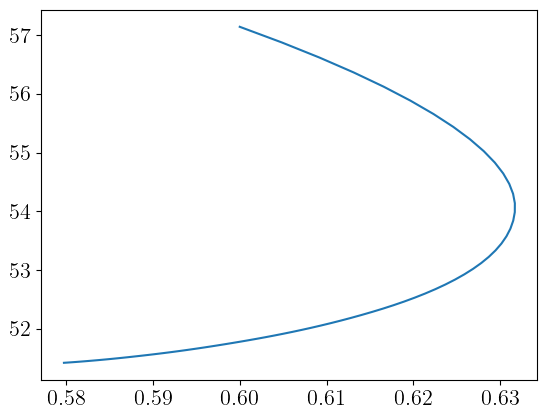

In [94]:
plt.plot(sol.y[2], sol.y[1])

In [95]:
xi_max = sol.y[2].max()
xi_max_index = sol.y[2].argmax()

In [96]:
v_prof = interpolate.interp1d(sol.y[2][0:xi_max_index+1],sol.y[0][0:xi_max_index+1])
T_prof = interpolate.interp1d(sol.y[2][0:xi_max_index+1],sol.y[1][0:xi_max_index+1])

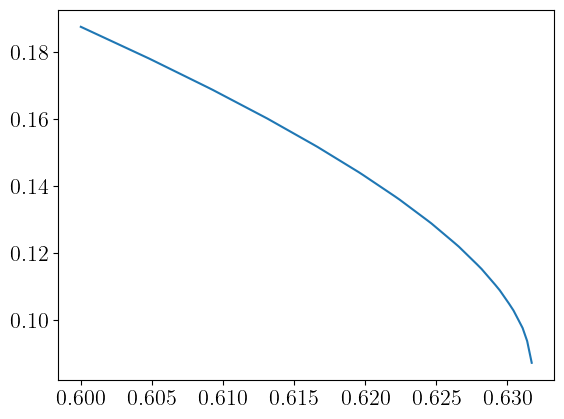

In [97]:
Plot(v_prof, (0.6, xi_max))

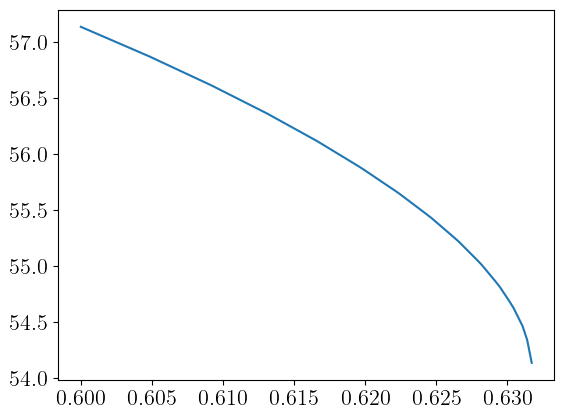

In [98]:
Plot(T_prof, (0.6, xi_max))

In [106]:
xsh = optimize.brentq(lambda x: μ(x, v_prof(x)) * x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max)
print(xsh)

0.6235328033067872


In [109]:
μ(xsh, v_prof(xsh))

0.53527682484128

In [111]:
def sh_match_2(Tshp):
    ap = alpha_p(Vtot, Tshp, T_prof(xsh), hv, hv)
    r = r_func(Vtot, Tshp, T_prof(xsh), hv, hv)
    vp = xsh
    vm = μ(xsh, v_prof(xsh))
    ratio = 3 + (1-3*ap)*r
    ratio = ratio/(1+3*(1+ap)*r)
    return vp/vm - ratio

In [112]:
optimize.newton(sh_match_2, T_prof(xsh))

51.42869487494407

In [110]:
find_Tsh(53, 0.6, 'hyb')

51.42773731139599

In [118]:
find_Tsh(55.925, 0.6, 'hyb')

53.312886246587354

In [128]:
Ttest=55.925
optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Ttest, lv)**0.5, x[1], Ttest,hv, lv),[0.1,Tnuc+3])

array([ 0.48737329, 59.45418053])

In [304]:
Tm = optimize.newton(lambda T: find_Tsh(T, 0.65, 'hyb') - Tnuc, 56)
print(Tm)

57.573460487528465


In [306]:
vp, Tp = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.5,Tm + 2])
print(vp)
print(Tp)

0.5079512245741028
60.46378009886314


In [307]:
vm =cs_sq(Vtot, Tm, lv)**0.5
print(vm)
print(Tm)
vp, Tp = optimize.fsolve(lambda x:match_T(x[0], vm, x[1], Tm,hv, lv),[0.5,Tm+2])
print(vp)
print(Tp)

0.5735208451926317
57.573460487528465
0.5079512245924611
60.46378009809929


## Solve detonation boundary conditions

In [16]:
from helperFunctions import vJ

In [316]:
vw=0.7
gsol=optimize.fsolve(lambda x:match(vw, x[0], Tnuc, x[1], hv, lv),[vw*0.7,Tnuc+2])

In [317]:
gsol

array([ 0.65777897, 56.15473738])

In [318]:
vJ(alpha_p(Vtot, Tnuc, gsol[1], hv, lv))

0.6711185294143294

In [335]:
vw=0.64
gsol=optimize.fsolve(lambda x:match(vw, x[0], Tnuc, x[1], hv, lv),[vw*0.9,Tnuc+2])
print(gsol)
print(vJ(alpha_p(Vtot, Tnuc, gsol[1], hv, lv)))

[ 0.56513831 57.61888155]
0.6549538212842086


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [14]:
def test_vJ(vw):
    gsol=optimize.fsolve(lambda x:match(vw, x[0], Tnuc, x[1], hv, lv),[vw*0.9,Tnuc+2])
    return vJ(alpha_p(Vtot, Tnuc, gsol[1], hv, lv))

/Users/tongou/miniconda3/envs/py3-10-9/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


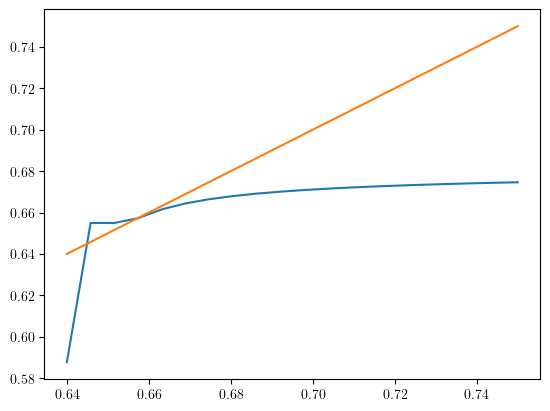

In [17]:
Plot(test_vJ, (0.64,0.75), n=20)
plt.plot(np.linspace(0.64,0.75,20), np.linspace(0.64,0.75,20))

In [18]:
vwmax = 1.0
eps = 0.01
for i in range(1000):
    vw = vwmax - i * eps
    if test_vJ(vw) > vw:
        vwmin = vw
        break
vJvalue = optimize.brentq(lambda vw:test_vJ(vw) - vw, vwmin, vwmin+eps)

/Users/tongou/miniconda3/envs/py3-10-9/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [19]:
vJvalue

0.6549523841230909

In [325]:
vw=0.7
vm,Tm =optimize.fsolve(lambda x:match(vw, x[0], Tnuc, x[1], hv, lv),[vw*0.7,Tnuc+2])
vp = vw
Tp = Tnuc
lv_new = optimize.fmin(Vtot, lv, args=(Tm,),disp=0)

In [323]:
- Tp/Sqrt(1-vp**2) + Tm/Sqrt(1-vm**2) # entropy difference, should be negative

-0.10827711654633276

In [331]:
Lh = 0.1
npoints = 100
z_range = np.linspace(-8*Lh, 5*Lh, npoints)
T_sol = np.zeros((npoints,))
for i in range(npoints):
    T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tp, method='Nelder-Mead', bounds = [(40, 90)])
    if T33min.fun > 0:
        T_sol[i]=T33min.x[0]
    else:
        try:
            s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tp)
        except:
            s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tp)[0]
        T_sol[i] = s

Tsol_list.append(T_sol)
hvalues = h_profile(z_range, Lh)
hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
inte = - Eh * hprime(z_range)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_11107/351620250.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


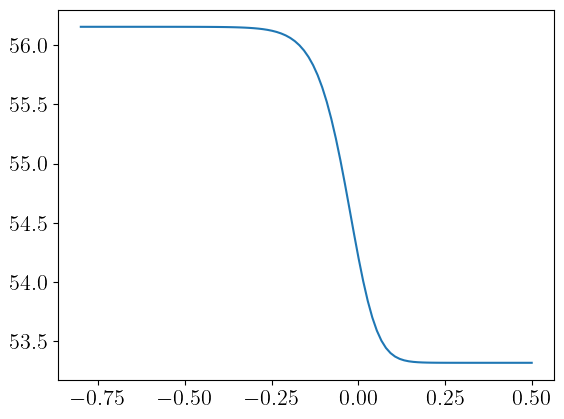

In [332]:
plt.plot(z_range, T_sol)

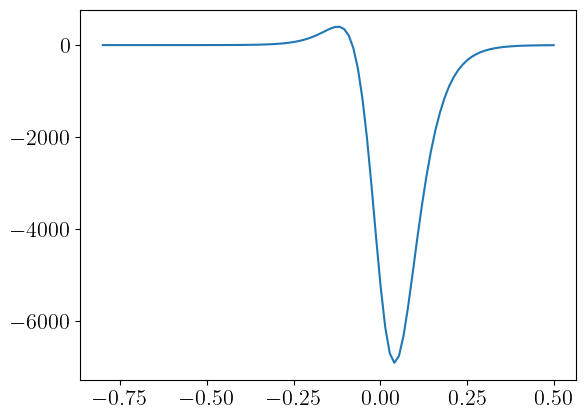

In [333]:
plt.plot(z_range, Eh)

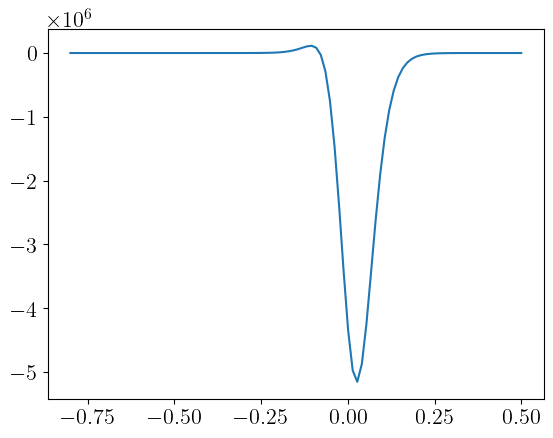

In [334]:
plt.plot(z_range, inte)

In [350]:
vwdet = np.linspace(vJvalue*1.01, 0.99, 5).tolist()
Pdet = []
sdiffdet = []

In [351]:
for vw in vwdet:
    print("vw = " + str(vw))
    vm,Tm =optimize.fsolve(lambda x:match(vw, x[0], Tnuc, x[1], hv, lv),[vw*0.7,Tnuc+2])
    vp = vw
    Tp = Tnuc
    lv_new = optimize.fmin(Vtot, lv, args=(Tm,),disp=0)
    h0 = lv_new

    sdiffdet.append(- Tp/Sqrt(1-vp**2) + Tm/Sqrt(1-vm**2))

    def h_profile(z, Lh):
        z = np.asanyarray(z)
        hz = 0.5*h0*(1-np.tanh(z/Lh))
        return hz
    c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
    s1=c1
    c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
    s2=c2
    def T33(T,z, Lh):
        derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
        field_value = [h_profile(z, Lh)]
        return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6
    
    def moments(Lh):
        npoints = 100
        z_range = np.linspace(-8*Lh, 5*Lh, npoints)
        T_sol = np.zeros((npoints,))
        for i in range(npoints):
            T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tp, method='Nelder-Mead', bounds = [(40, 90)])
            if T33min.fun > 0:
                T_sol[i]=T33min.x[0]
            else:
                try:
                    s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tp)
                except:
                    s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tp)[0]
                T_sol[i] = s

        hvalues = h_profile(z_range, Lh)
        hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
        d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
        Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))

        Ph = np.trapz(- Eh * hprime(z_range), z_range)
        Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
        return np.array([Ph, Gh])/1e6
    
    print('Solving moments.')
    Lsol = optimize.newton(lambda L: moments(L)[-1], 0.2)
    print('Moment solved, Lh = ' + str(Lsol))
    P = moments(Lsol)[0]
    Pdet.append(P)


vw = 0.6615041780659539
Solving moments.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_11107/217839514.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Moment solved, Lh = 0.13397504521690212
vw = 0.7436281335494654
Solving moments.
Moment solved, Lh = 0.13231580377855168
vw = 0.8257520890329769
Solving moments.
Moment solved, Lh = 0.12907249895901224
vw = 0.9078760445164884
Solving moments.
Moment solved, Lh = 0.12749439102614515
vw = 0.99
Solving moments.
Moment solved, Lh = 0.1265732618770968


In [353]:
Pdet

[-0.3772469314146626,
 -0.6842367673870648,
 -0.7785859295748131,
 -0.8258308006870283,
 -0.8541361718022109]

In [354]:
sdiffdet

[-0.06627218142820368,
 -0.13803389947514688,
 -0.18846838200938976,
 -0.2706901649670357,
 -0.8353388043871064]

In [355]:
vwlist

[0.1, 0.18, 0.25, 0.33, 0.4, 0.48, 0.55, 0.6]

In [356]:
Plist.tolist()

array([-1.13967089, -1.10989716, -1.07182336, -1.00850629, -0.92029511,
       -0.72301204, -0.26152625,  0.61461885])

In [358]:
Plist

array([-1.13967089, -1.10989716, -1.07182336, -1.00850629, -0.92029511,
       -0.72301204, -0.26152625,  0.61461885])

In [357]:
sdifflist

array([-0.16469655, -0.16121641, -0.15682295, -0.14911955, -0.13719636,
       -0.10738916, -0.03672801,  0.07572929])

In [359]:
Pfinal = Plist.tolist() + Pdet
sdifffinal = sdifflist.tolist() + sdiffdet

In [361]:
vwfinal = vwlist + vwdet.tolist()

Text(0, 0.5, '$P_{\\rm tot}$')

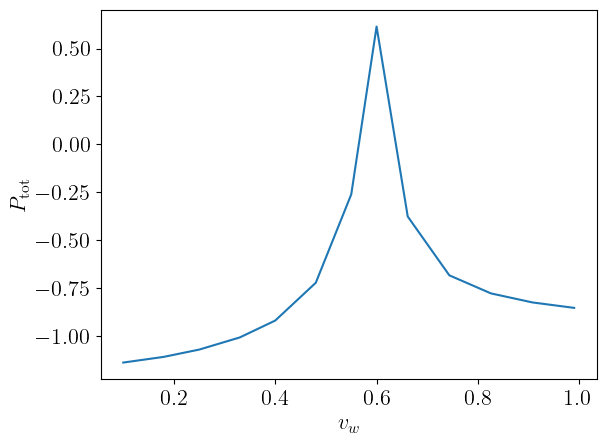

In [363]:
plt.plot(vwfinal, Pfinal)
plt.xlabel(r'$v_w$')
plt.ylabel(r'$P_{\rm tot}$')

Text(0, 0.5, '$\\Delta (s \\gamma v)$')

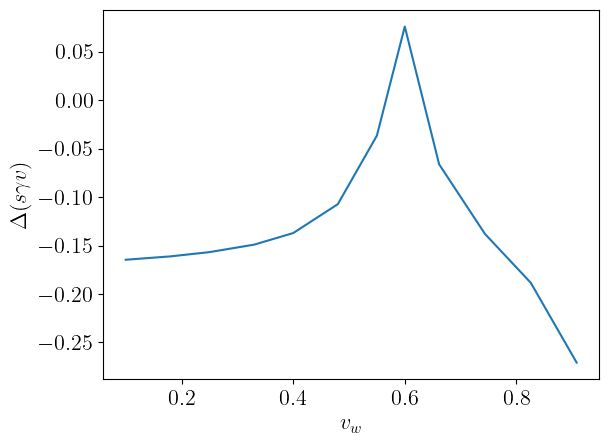

In [365]:
plt.plot(vwfinal[0:-1], sdifffinal[0:-1])
plt.xlabel(r'$v_w$')
plt.ylabel(r'$\Delta (s \gamma v)$')

## Solve the temperature profile and the moments

In [326]:
h0 = lv_new

def h_profile(z, Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz
c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
s1=c1
c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
s2=c2

In [327]:
def T33(T,z, Lh):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    field_value = [h_profile(z, Lh)]
    return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

In [286]:
vwlist = [0.4,0.5,0.6]
Tsol_list = []
Ehlist = []
intelist = []
for vw in vwlist:
    # Test solution type. Start from deflagration to test.
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc)
    lv_new = mod.findMinimum(lv, Tm)
    if cs_sq(Vtot, Tm, lv_new)**0.5 > vw:
        print("Deflagration.")
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = vw
    else:
        print("Hybrid.")
        Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc+1)
        lv_new = mod.findMinimum(lv, Tm)
        vm = cs_sq(Vtot, Tm,lv_new)**0.5
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vm,x[1], Tm, hv, lv),[0.5, Tnuc+3], xtol=1e-10)
        print("Boundary condition found.")

    h0 = lv_new

    def h_profile(z, Lh):
        z = np.asanyarray(z)
        hz = 0.5*h0*(1-np.tanh(z/Lh))
        return hz

    c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
    s1=c1
    c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
    s2=c2

    def T33(T,z, Lh):
        derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
        field_value = [h_profile(z, Lh)]
        return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

    print('T33 prepared.')
    
    Lh = 0.1
    npoints = 100
    z_range = np.linspace(-8*Lh, 5*Lh, npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tp, method='Nelder-Mead', bounds = [(40, 90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tp)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tp)[0]
            T_sol[i] = s

    Tsol_list.append(T_sol)
    hvalues = h_profile(z_range, Lh)
    hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
    d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
    Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
    inte = - Eh * hprime(z_range)

    Ehlist.append(Eh)
    intelist.append(inte)

Deflagration.
T33 prepared.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_11107/592092013.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Deflagration.
T33 prepared.
Hybrid.


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Boundary condition found.
T33 prepared.


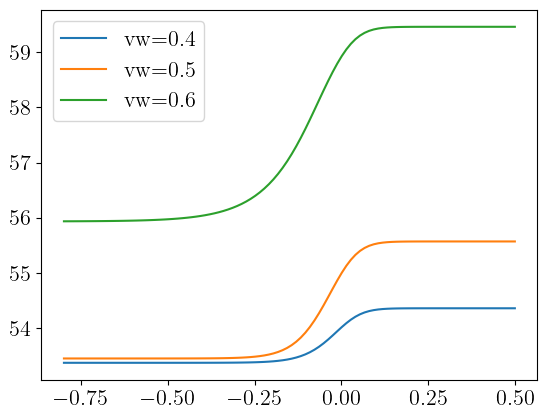

In [287]:
for i in range(3):
    plt.plot(z_range, Tsol_list[i], label=f'vw={vwlist[i]}')

plt.legend()

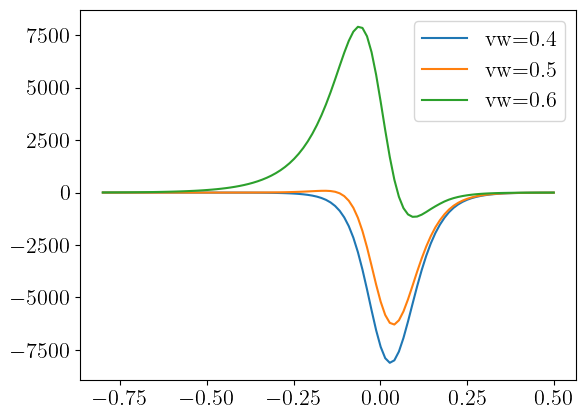

In [288]:
for i in range(3):
    plt.plot(z_range, Ehlist[i], label=f'vw={vwlist[i]}')

plt.legend()

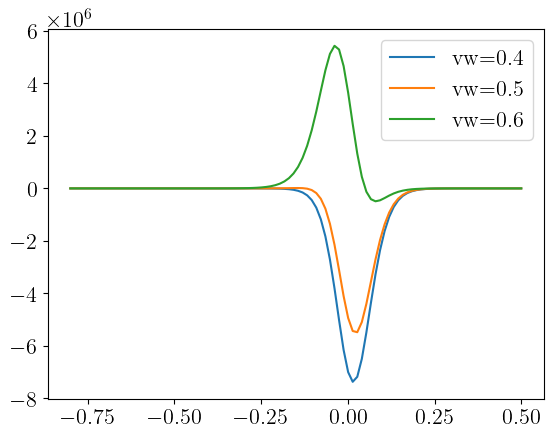

In [289]:
for i in range(3):
    plt.plot(z_range, intelist[i], label=f'vw={vwlist[i]}')

plt.legend()

In [268]:
np.trapz(intelist[2], z_range)/1e6

0.5838843622798291

In [328]:
def moments(Lh):
    npoints = 100
    z_range = np.linspace(-8*Lh, 5*Lh, npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tp, method='Nelder-Mead', bounds = [(40, 90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tp)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tp)[0]
            T_sol[i] = s

    hvalues = h_profile(z_range, Lh)
    hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
    d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
    Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
    Ph = np.trapz(- Eh * hprime(z_range), z_range)
    Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
    return np.array([Ph, Gh])/1e6

In [330]:
moments(0.1)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_11107/2217937712.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


array([-0.56750735, -0.16891291])

In [293]:
moments(0.3)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_11107/2217937712.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


array([0.62055401, 0.05432061])

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_11107/2217937712.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


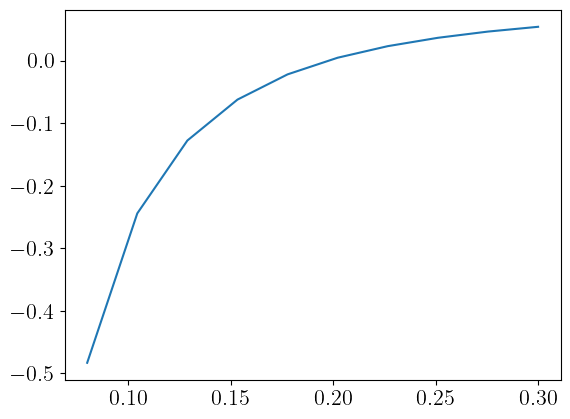

In [294]:
Plot(lambda Lh: moments(Lh)[-1], (0.08,0.3), n=10)

In [165]:
vwlist = np.linspace(0.1,0.55,6)
Plist = np.zeros((6,))

In [166]:
vwlist = [round(vw,2) for vw in vwlist]

In [296]:
def Ptot(vw):
    # Test solution type. Start from deflagration to test.
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc)
    lv_new = mod.findMinimum(lv, Tm)
    if cs_sq(Vtot, Tm, lv_new)**0.5 > vw:
        print("Deflagration.")
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = vw
    else:
        print("Hybrid.")
        Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc+1)
        lv_new = mod.findMinimum(lv, Tm)
        vm = cs_sq(Vtot, Tm,lv_new)**0.5
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vm,x[1], Tm, hv, lv),[0.5, Tnuc+3], xtol=1e-10)
        print("Boundary condition found.")


    hv_new = mod.findMinimum(hv, Tp)
    h0 = lv_new

    def h_profile(z, Lh):
        z = np.asanyarray(z)
        hz = 0.5*h0*(1-np.tanh(z/Lh))
        return hz
    c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
    s1=c1
    c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
    s2=c2

    def T33(T,z, Lh):
        derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
        field_value = [h_profile(z, Lh)]
        return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

    print('T33 prepared.')
    
    def moments(Lh):
        npoints = 100
        z_range = np.linspace(-8*Lh, 5*Lh, npoints)
        T_sol = np.zeros((npoints,))
        for i in range(npoints):
            T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tp, method='Nelder-Mead', bounds = [(40, 90)])
            if T33min.fun > 0:
                T_sol[i]=T33min.x[0]
            else:
                try:
                    s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tp)
                except:
                    s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tp)[0]
                T_sol[i] = s

        hvalues = h_profile(z_range, Lh)
        hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
        d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
        Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
        Ph = np.trapz(- Eh * hprime(z_range), z_range)
        Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
        return np.array([Ph, Gh])/1e6
    print('Solving moments.')
    Lsol = optimize.newton(lambda L: moments(L)[-1], 0.2)
    print('Moment solved, Lh = ' + str(Lsol))
    P = moments(Lsol)[0]
    return P

In [297]:
Ptot(0.6)

Hybrid.


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Boundary condition found.
T33 prepared.
Solving moments.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_11107/198521261.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Moment solved, Lh = 0.19697792187251661


0.6146188510544172

In [298]:
vwlist = np.linspace(0.1, 0.55, 7)
vwlist = [round(vw,2) for vw in vwlist]
vwlist.append(0.6)
Plist=np.ones((8,))

In [299]:
for i in range(len(vwlist)):
    vw = vwlist[i]
    Plist[i] = Ptot(vw)
    print(Plist[i])

Deflagration.
T33 prepared.
Solving moments.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_11107/198521261.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Moment solved, Lh = 0.11817805433388351
-1.139670891193716
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11829393452597012
-1.1098971647521931
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.1183977660827226
-1.071823362349121
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11852240342309264
-1.0085062880514886
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11873328519248504
-0.9202951053243743
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11999730273998373
-0.7230120406423143
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.13141286643355324
-0.2615262477505727
Hybrid.


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Boundary condition found.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.19697792187251661
0.6146188510544172


Text(0, 0.5, '$P_{\\rm tot}$')

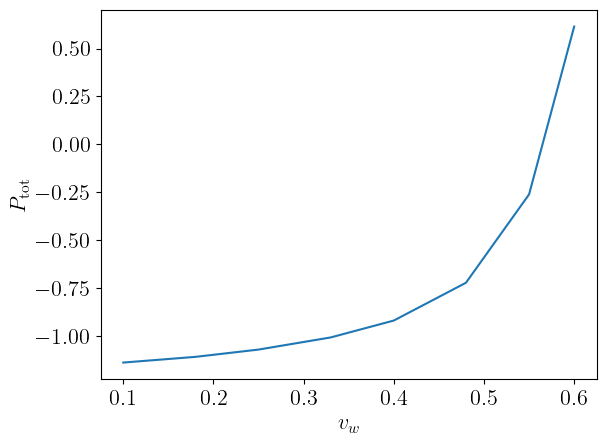

In [300]:
plt.plot(vwlist, Plist)
plt.xlabel(r'$v_w$')
plt.ylabel(r'$P_{\rm tot}$')

In [301]:
Ptot(0.65)

RuntimeError: Failed to converge after 50 iterations, value is 53.64697073807108.

## Solve entropy vanishing instead of P vanishing

In [44]:
def entropy(V,T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)

    def VT(T):
        return V(v, T)
    
    return -derivative(VT, T, order=1)

In [129]:
def sdiff(vw):
    print("vw = " + str(vw))
    # Test solution type. Start from deflagration to test.
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc-1)
    lv_new = mod.findMinimum(lv, Tm)
    if cs_sq(Vtot, Tm, lv_new)**0.5 > vw:
        print("Deflagration.")
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = vw
    else:
        print("Hybrid.")
        Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc)
        lv_new = mod.findMinimum(lv, Tm)
        vp, Tp = optimize.fsolve(lambda x:match(x[0],cs_sq(Vtot, Tm,lv_new)**0.5,x[1], Tm, hv, lv),[0.5, Tnuc+3], xtol=1e-10)
        vm = cs_sq(Vtot, Tm,lv_new)**0.5

    lv_new = mod.findMinimum(lv, Tm)

    diff = - Tp/Sqrt(1-vp**2) + Tm/Sqrt(1-vm**2)
    # diff = (- entropy(Vtot, Tp, hv) * vp/Sqrt(1-vp**2) + entropy(Vtot, Tm, lv_new) * vw/Sqrt(1-vw**2))/1e6
    return diff

In [131]:
sdiff(0.6)

vw = 0.6
Hybrid.


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.07572928778000687

In [145]:
vwlist = np.linspace(0.1, 0.55, 7)
vwlist = [round(vw,2) for vw in vwlist]
vwlist.append(0.6)
sdifflist = np.zeros((8,))

In [147]:
for i in range(len(vwlist)):
    sdifflist[i] = sdiff(vwlist[i])
    print(sdifflist[i])

vw = 0.1
Deflagration.
-0.16469655407827588
vw = 0.18
Deflagration.
-0.16121641140055232
vw = 0.25
Deflagration.
-0.15682295189592566
vw = 0.33
Deflagration.
-0.14911955187093895
vw = 0.4
Deflagration.
-0.13719635855872525
vw = 0.48
Deflagration.
-0.10738916436063306
vw = 0.55
Deflagration.
-0.036728012696571
vw = 0.6
Hybrid.


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.07572928778000687


Text(0, 0.5, '$\\Delta (s \\gamma v)$')

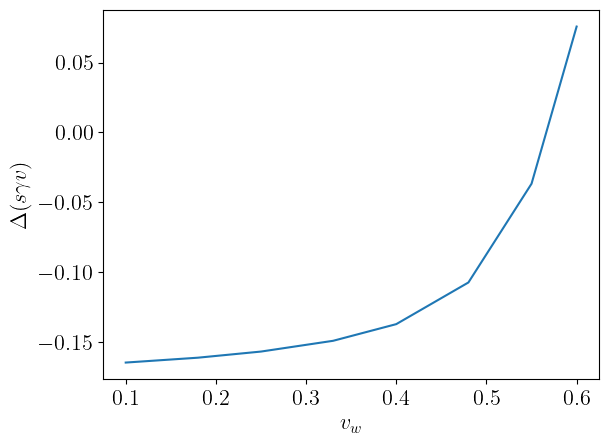

In [148]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')
plt.plot(vwlist, sdifflist)
plt.xlabel(r'$v_w$')
plt.ylabel(r'$\Delta (s \gamma v)$')

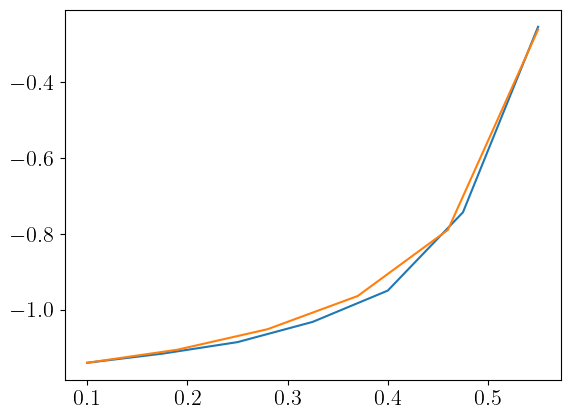

In [243]:
plt.plot(np.linspace(0.1, 0.55, 7),(Plist[0]/sdifflist[0])*sdifflist[0:-1])
plt.plot(vwlist, Plist)